In [1]:
from simulation import Simulation
from maker import SimpleMarketMaker, OrderType
from typing import List, Tuple, Literal

from data_maker import DataMarketMaker, run_mm, run_mm_plus, plot_defaults

import numpy as np

In [2]:
class ExampleDataMarketMaker(DataMarketMaker):
    def update(self, prev_bid_price, prev_ask_price, holding, money, timestamp):
        return prev_bid_price, 0, prev_ask_price, 0, OrderType.new_limit_order(timestamp, timestamp + 100)

In [3]:
data = run_mm_plus(ExampleDataMarketMaker())

Running
Total profit: 0.0
Total holding: 0 at price 102.10910034179688 for a total of 0.0
Total cash: 10000
Final Revenue: 10000.0
Game completed in 0.8996689319610596 seconds


In [4]:
class BadStrategy(DataMarketMaker):
        """
        An example on how to implement a market maker.
        """
        def __init__(self):
            self.prev_bid_history = []
            self.prev_ask_history = []
            
            self.window = 10
            self.simulations = 10
            self.sim_horizon = 3
            
            self.tracker.config_info(["Simulated Price", "Simulated Std"]) # Allow tracker to recognize data points
       
        def update(self, prev_bid_price, prev_ask_price, holding, money, timestamp) -> Tuple[float, int, float, int, OrderType]:
                        
            self.prev_bid_history.append(prev_bid_price)
            self.prev_ask_history.append(prev_ask_price)
            
            mean, std = self.simulate()
            self.tracker.update_info(mean, std) # Keep track of info
            
            buy_dev = std * -0.1
            sell_dev = std * 0.1
            
            max_buy_price = prev_bid_price + buy_dev
            max_sell_price = prev_ask_price + sell_dev
            
            return max_buy_price, int(money/max_buy_price - 1) // 2, max_sell_price, holding//2, OrderType.new_limit_order(timestamp, timestamp + 100)
        
        def simulate(self): 
            if len(self.prev_bid_history) < self.window: 
                avg_orig_price = (self.prev_bid_history[0] + self.prev_ask_history[0])/2
                return avg_orig_price, 0.05 * avg_orig_price
            
            price_history = (np.array(self.prev_bid_history[-self.window:]) + np.array(self.prev_ask_history[-self.window:])) / 2
            diffs = np.diff(np.log(price_history))
            
            std = np.std(diffs) ** 2
            drift = np.mean(diffs) + std ** 2 / 2
            
            future = []
            for _ in range(self.simulations): 
                future.append(np.cumsum(np.random.normal(drift, std, self.sim_horizon)))
                
            future_prices_estimates = price_history[-1] * np.exp(np.array(future))

            return np.mean(future_prices_estimates), np.std(future_prices_estimates)  

In [5]:
strat = BadStrategy()
data = run_mm_plus(strat)

Running
Total profit: -9623.121627807617
Total holding: 1 at price 97.05177307128906 for a total of 97.05177307128906
Total cash: 279.82659912109375
Final Revenue: 376.8783721923828
Game completed in 10.751013994216919 seconds


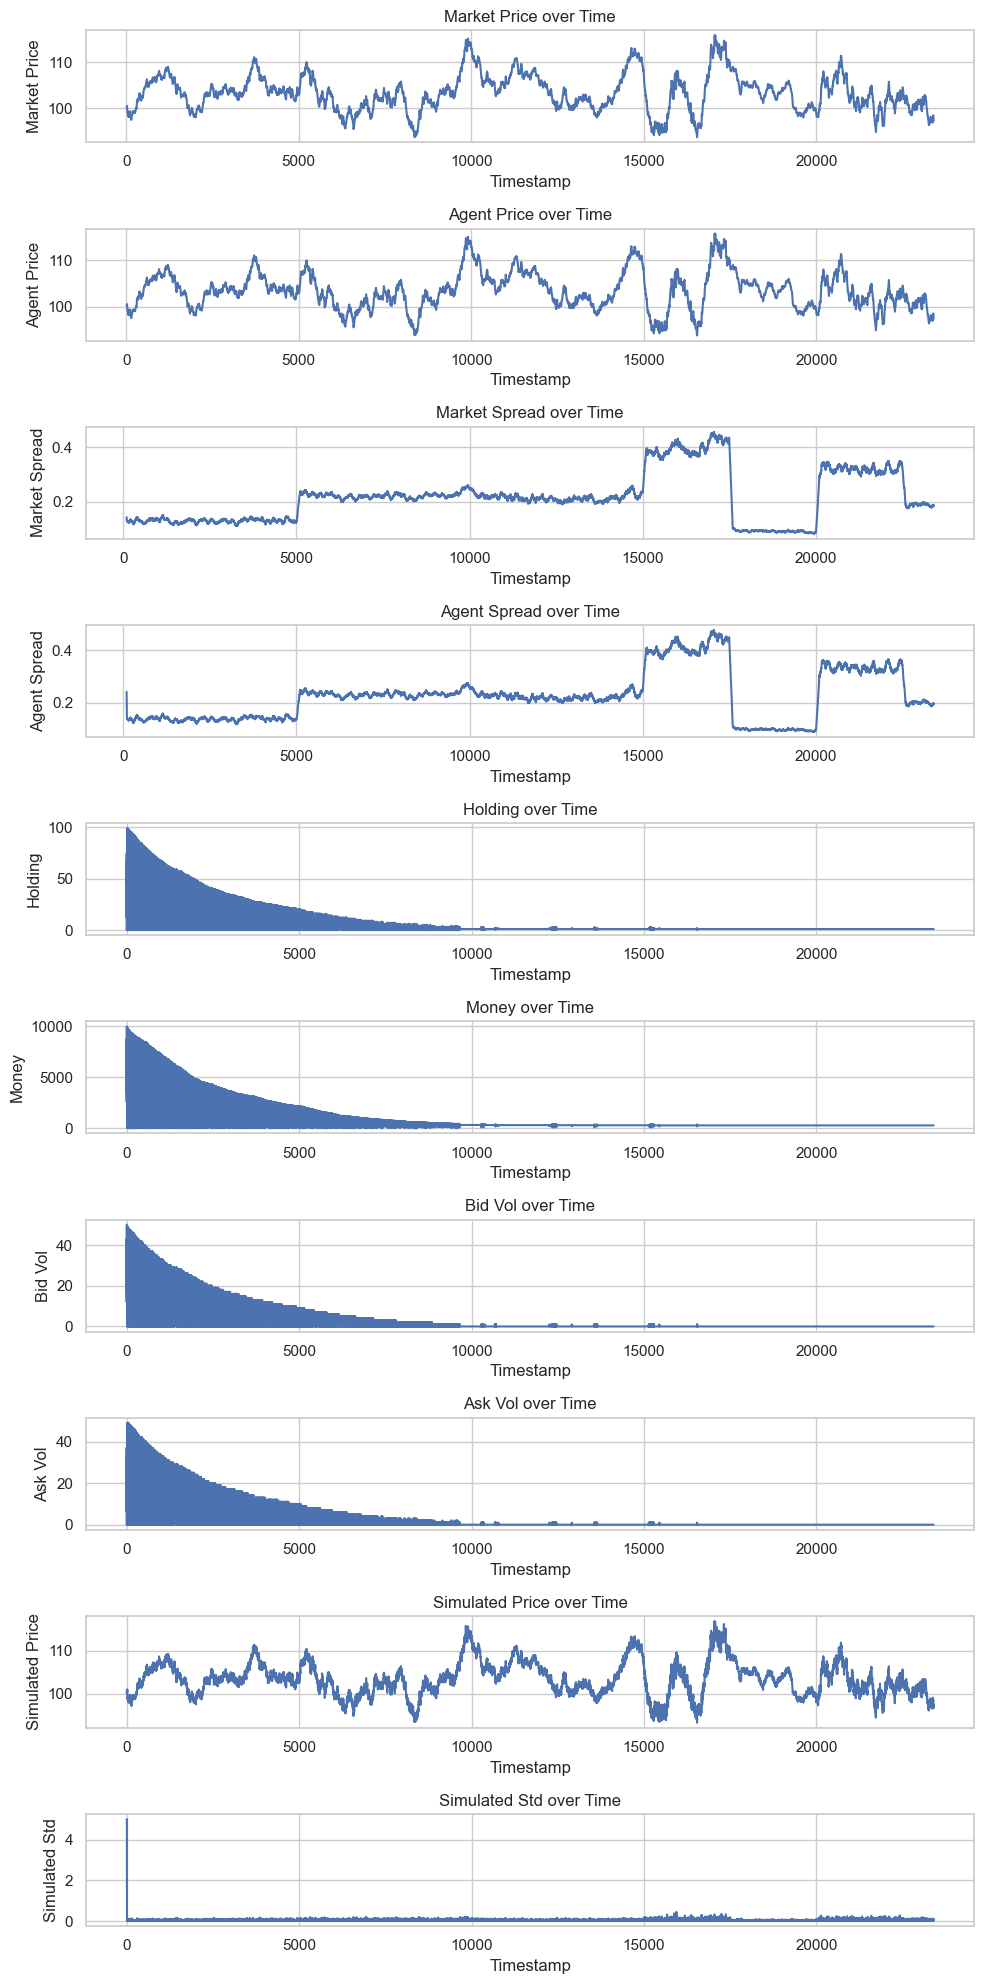

In [6]:
plot_defaults(data, additional_cols = ["Simulated Price", "Simulated Std"])

In [14]:
def simulate(price_history): 
    diffs = np.diff(np.log(price_history))

    std = np.std(diffs) ** 2
    drift = np.mean(diffs) + std ** 2 / 2

    future = []
    for _ in range(1): 
        future.append(np.cumsum(np.random.normal(drift, std, 3)))

    future_prices_estimates = price_history[-1] * np.exp(np.array(future))

    return np.mean(future_prices_estimates), np.std(future_prices_estimates)    

In [15]:
price_history = np.random.normal(100, 0.5, 20) + np.cumsum(np.random.normal(1, 0.5, 20))
print(price_history)
simulate(price_history)

[101.94087717 102.17267505 104.09366049 103.71003932 104.08501087
 106.29518227 108.92588815 109.31288617 110.34467447 111.43801433
 112.393694   113.43879469 114.22295868 116.3237531  116.01458192
 117.52330199 118.2858576  119.03501367 121.3484859  122.70638794]


(125.13192277656866, 1.0011643601251115)